In [3]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Function to calculate KL Divergence
def kl_divergence(p, q, epsilon=1e-10):
    """
    Calculates KL divergence between two probability distributions.
    Args:
        p (np.array): Probability distribution of reference data.
        q (np.array): Probability distribution of incoming data.
        epsilon (float): Small value to avoid log(0).
    Returns:
        float: KL Divergence between distributions.
    """
    p = p + epsilon  # to avoid division by zero
    q = q + epsilon  # to avoid division by zero
    return entropy(p, q)

# Function to create histograms for data and normalize to probability distribution
def calculate_histogram(data, bins=50):
    """
    Creates a histogram and converts it to a probability distribution.
    Args:
        data (np.array): The data for which to compute the histogram.
        bins (int): Number of histogram bins.
    Returns:
        np.array: Normalized histogram (probability distribution).
    """
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    return hist / np.sum(hist), bin_edges



In [14]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

class FEDD:
    def __init__(self, window_size=300, lambda_value=0.2, warning_threshold=1.0, drift_threshold=1.5, metric='cosine'):
        self.window_size = window_size
        self.lambda_value = lambda_value
        self.warning_threshold = warning_threshold
        self.drift_threshold = drift_threshold
        self.metric = metric
        self.feature_vector_init = None
        self.drift_detected = False

    def compute_features(self, data):
        # Autocorrelation at first five lags
        autocorr = [np.corrcoef(data[:-lag], data[lag:])[0, 1] for lag in range(1, 6)]
        
        # Variance
        variance = np.var(data)
        
        # Skewness
        skewness = np.mean((data - np.mean(data))**3) / np.std(data)**3
        
        # Kurtosis
        kurtosis = np.mean((data - np.mean(data))**4) / np.std(data)**4
        
        # Combine features into vector
        feature_vector = np.hstack((autocorr, variance, skewness, kurtosis))
        return feature_vector

    def distance(self, v1, v2):
        if self.metric == 'cosine':
            return 1 - cosine_similarity([v1], [v2])[0][0]
        elif self.metric == 'pearson':
            return 1 - pearsonr(v1, v2)[0]

    def update_EWMA(self, dist, prev_EWMA, count):
        return (1 - self.lambda_value) * prev_EWMA + self.lambda_value * dist if count > 0 else dist

    def detect_drift(self, data_stream):
        warning_signal = False
        count = 0
        EWMA_dist = 0
        below_warn = 0
        for i in range(len(data_stream) - self.window_size):
            current_window = data_stream[i:i + self.window_size]
            feature_vector = self.compute_features(current_window)
            
            if self.feature_vector_init is None:
                self.feature_vector_init = feature_vector
                continue

            dist = self.distance(self.feature_vector_init, feature_vector)
            EWMA_dist = self.update_EWMA(dist, EWMA_dist, count)
            count += 1

            # Check for warning signal
            if not warning_signal and EWMA_dist > (self.warning_threshold * np.std(EWMA_dist)):
                warning_signal = True
                print(f"Warning at index {i}")

            # Check for drift signal
            if EWMA_dist > (self.drift_threshold * np.std(EWMA_dist)):
                self.drift_detected = True
                print(f"Drift detected at index {i}")
                break

            # Reset warning if stable for some time
            if warning_signal and EWMA_dist < (self.warning_threshold * np.std(EWMA_dist)):
                below_warn += 1
                if below_warn >= 10:
                    warning_signal = False
                    below_warn = 0


In [10]:
# Generate synthetic reference data and incoming data stream
np.random.seed(42)
reference_data = np.random.normal(loc=0.0, scale=1.0, size=(1000, 3))  # reference data (3 features)
incoming_data_normal = np.random.normal(loc=0.0, scale=1.0, size=(100, 3))  # normal incoming data
incoming_data_drift = np.random.normal(loc=2.0, scale=1.0, size=(100, 3))  # data after concept drift

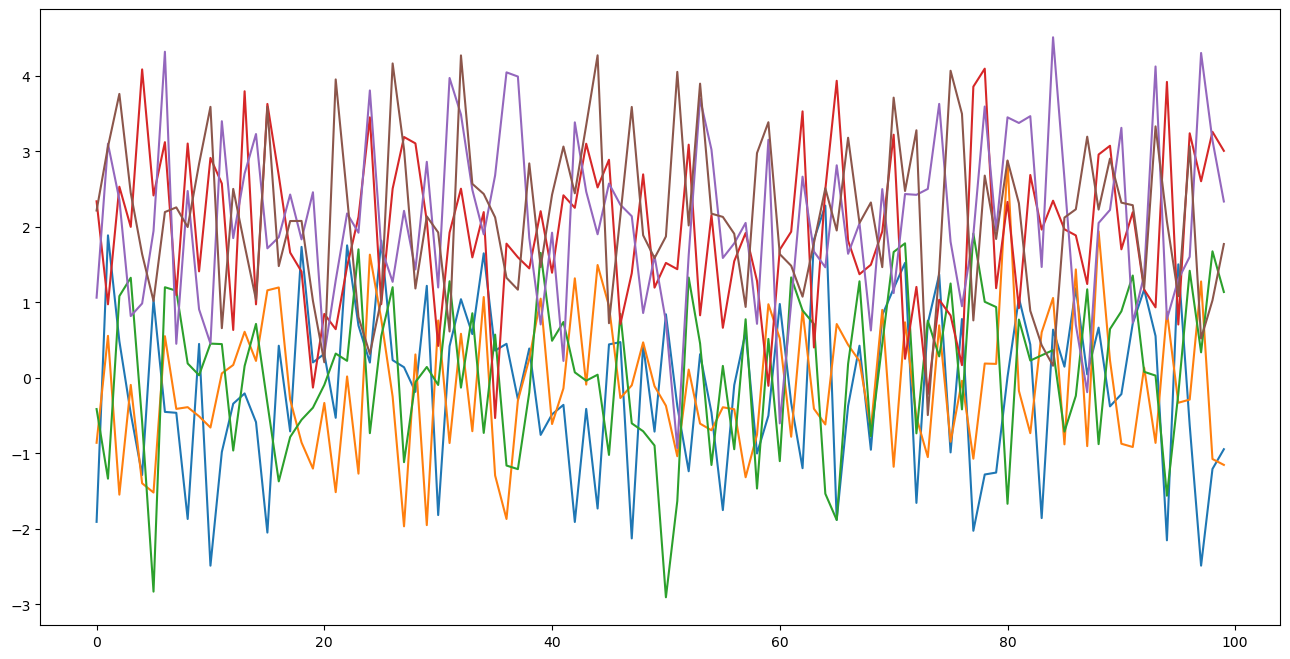

In [11]:
plt.figure(figsize=(16,8))
# plt.plot(reference_data)
plt.plot(incoming_data_normal)
plt.plot(incoming_data_drift)
plt.show()

In [12]:
# Function to detect concept drift using KL Divergence
def detect_concept_drift(reference_data, incoming_data, threshold=0.5, bins=50):
    """
    Detects concept drift by comparing KL Divergence between reference and incoming data.
    Args:
        reference_data (np.array): Reference data (before drift).
        incoming_data (np.array): Incoming data stream (current data).
        threshold (float): KL Divergence threshold for detecting drift.
        bins (int): Number of bins for the histograms.
    Returns:
        list: KL divergence values for each feature and drift detection status.
    """
    num_features = reference_data.shape[1]
    kl_values = []
    drift_detected = False
    
    for feature_idx in range(num_features):
        ref_hist, _ = calculate_histogram(reference_data[:, feature_idx], bins)
        inc_hist, _ = calculate_histogram(incoming_data[:, feature_idx], bins)
        kl_div = kl_divergence(ref_hist, inc_hist)
        kl_values.append(kl_div)
        
        if kl_div > threshold:
            drift_detected = True
    
    return kl_values, drift_detected



In [13]:
# Detect drift between reference data and incoming data (normal and drifted)
kl_values_normal, drift_detected_normal = detect_concept_drift(reference_data, incoming_data_normal)
kl_values_drift, drift_detected_drift = detect_concept_drift(reference_data, incoming_data_drift)

# Output the results
print("KL Divergence (Normal Data):", kl_values_normal)
print("Drift Detected (Normal Data):", drift_detected_normal)
print("\nKL Divergence (Drifted Data):", kl_values_drift)
print("Drift Detected (Drifted Data):", drift_detected_drift)


KL Divergence (Normal Data): [3.2315022533901967, 1.9098835079593113, 1.7312824187668565]
Drift Detected (Normal Data): True

KL Divergence (Drifted Data): [1.3956453510809823, 1.1797795072124682, 1.4571972208374457]
Drift Detected (Drifted Data): True


In [17]:
data_stream = np.random.normal(size=1000)  # Simulated time series data
fedd = FEDD(window_size=100, metric='pearson')
fedd.detect_drift(incoming_data_drift)
